## As mentioned previously, our Random Forest Model was overfitting and so in this notebook, we will try to improve it.

## Import Basic Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin

# A custom transformer to convert data to dense format
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [2]:
data = pd.read_csv('shopping_behavior_updated.csv')

## Naive Bayes Model (Reduced dataset)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8430769230769231

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8307692307692308



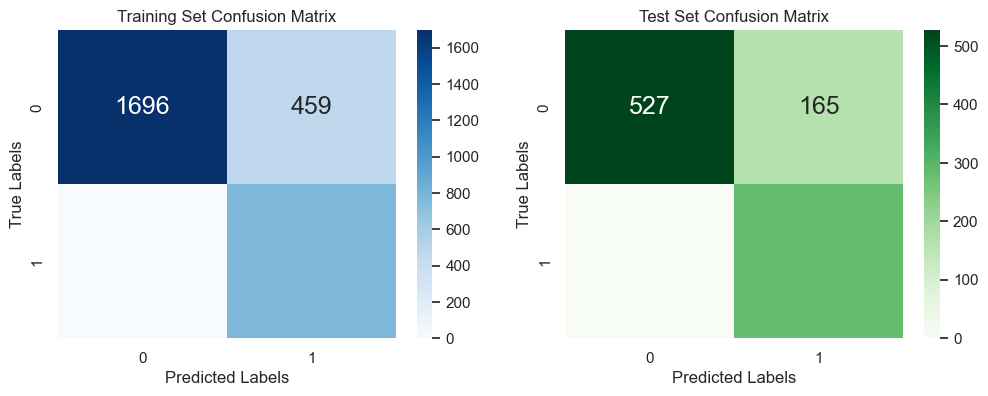

In [3]:
# Separate features and target
X = data[['Discount Applied', 'Purchase Amount (USD)']]
y = data['Subscription Status'].map({'Yes': 1, 'No': 0})  # Encoding target variable

# Preprocessing steps
numeric_features = ['Purchase Amount (USD)']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['Discount Applied']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('to_dense', DenseTransformer())  # Ensure dense format
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predictions for evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Classification Accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", model.score(X_train, y_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", model.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test sets
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[0], cmap='Blues')
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sb.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[1], cmap='Greens')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

#### After reducing our features to only Discount Applied and Purchase Amount (USD), our Naive Bayes Model still performs the same. This shows that all the other features removed may be redundant afterall.

## Random Forest Model (Reduced Dataset)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8547008547008547

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8143589743589743



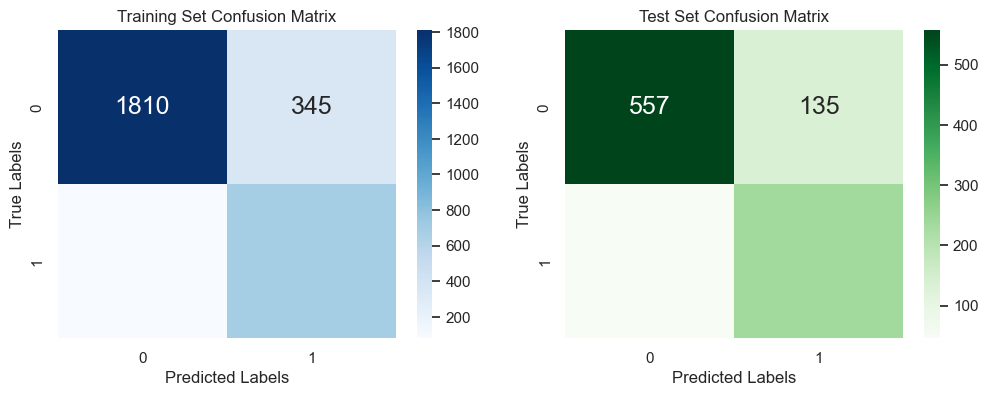

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create the modeling pipeline with Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Fit the Random Forest model
rf_model.fit(X_train, y_train)

# Predictions for evaluation
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Classification Accuracy
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rf_model.score(X_train, y_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rf_model.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test sets
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred_rf), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[0], cmap='Blues')
axes[0].set_title('Training Set Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sb.heatmap(confusion_matrix(y_test, y_test_pred_rf), annot=True, fmt=".0f", 
           annot_kws={"size": 18}, ax=axes[1], cmap='Greens')
axes[1].set_title('Test Set Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plt.show()

#### Compared to before, our Random Forest Model is now performing very well, with difference in train and test accuracy of around 4%. This is a huge improvement and we can tell that by removing redundant features, we have reduced the overfitting issue significantly

#### However, more can still be done to improve our test accuracy. Now, we shall implement GridSearch to get the best hyperparameters for our Random Forest Model.

## GridSearch on Random forest Model

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [80, 100, 120, 140],
    'classifier__max_depth': [2,3,4,5,6,7],  # Limit the maximum depth
    'classifier__min_samples_split': [5, 10, 15],  # Increase minimum samples required to split
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6],  # Increase minimum samples required at each leaf node
    'classifier__max_features': ['auto', 'sqrt', 'log2']  # Reduce number of features considered
}


# Perform grid search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test accuracy of the best model:", test_accuracy)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best hyperparameters: {'classifier__max_depth': 6, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 140}
Best score: 0.8468376068376069
Test accuracy of the best model: 0.8307692307692308


D:\Apps\Anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


#### After GridSearch, our Random Forest Model improved slightly of around 3% and the difference between train and test accuracy is further reduced to around 1%.